# Multitask GP Regression using pymc with GP LatentKron
Data Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [1]:
import numpy as np
import pymc as pm
from pymc.gp.cov import Covariance
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [2]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Set up training data: same X, three Y outputs

In [3]:
train_x = np.linspace(0, 1, 50)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [4]:
train_x.shape, train_y.shape

((50,), (50, 3))

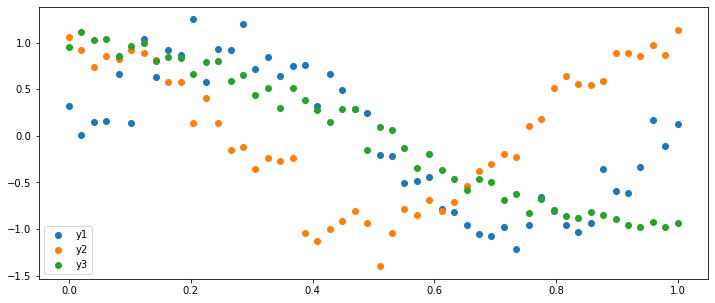

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [6]:
train_x.shape, train_y.shape

((50,), (50, 3))

In [7]:
x = train_x.reshape(-1,1)
y = train_y.reshape(-1,1)
x.shape, y.shape

((50, 1), (150, 1))

In [8]:
task_i = np.linspace(0, 2, 3)[:, None]
Xs = [x, task_i] # For training
Xs[0].shape, Xs[1].shape, x.shape

((50, 1), (3, 1), (50, 1))

In [9]:
Xnew = pm.math.cartesian(x, task_i) # For prediction
Xnew.shape

(150, 2)

### Option 1: Implement ICM (one kernel) by using LatentKron with Coregion kernel

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

#### Create a model

In [10]:
with pm.Model() as model:
    # Kernel: K_1(x,x')
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    # Coregion B matrix: K_2(o,o')
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)
    
    # Specify the GP.  The default mean function is `Zero`.
    mogp = pm.gp.LatentKron(cov_funcs=[cov, coreg])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    # Place a GP prior over thXse function f.
    f = mogp.prior("f", Xs=Xs)
    y_ = pm.Normal("y_", mu=f, sigma=sigma, observed=y.squeeze())    

In [11]:
coreg.full(task_i).eval()

array([[ 9.96263739,  5.92879303, 14.14139295],
       [ 5.92879303, 43.70651212, -8.10341629],
       [14.14139295, -8.10341629, 29.13545775]])

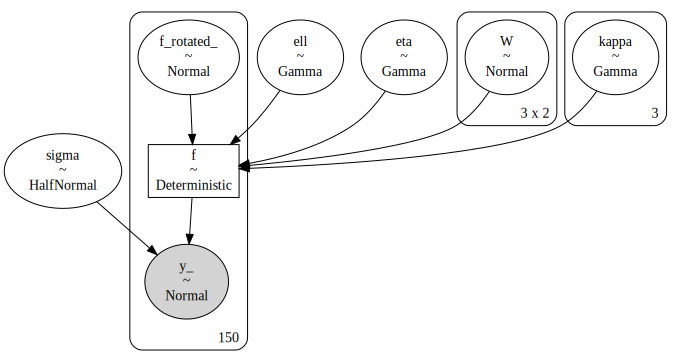

In [12]:
pm.model_to_graphviz(model)

In [13]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma, f_rotated_]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 260 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 10min 49s, sys: 23min 11s, total: 34min
Wall time: 4min 28s


#### Prediction

In [14]:
with model:
    preds = mogp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

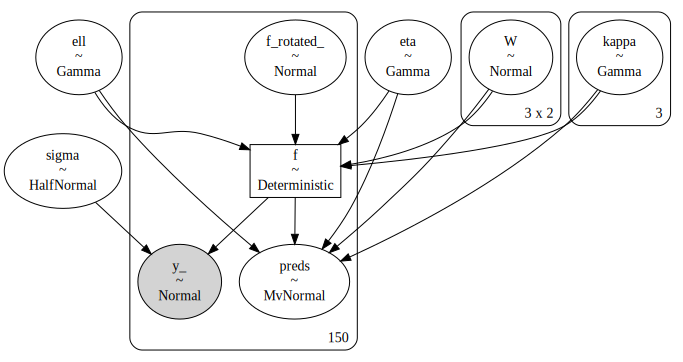

In [15]:
pm.model_to_graphviz(model)

In [16]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 150)

#### Plot the first GP

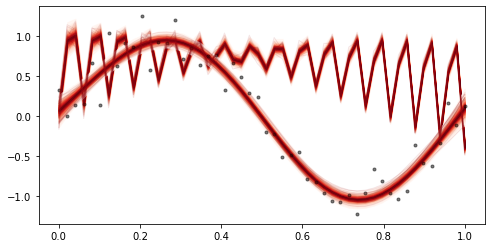

In [17]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 0:50], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 0], x)
plt.show()

#### Plot the second GP

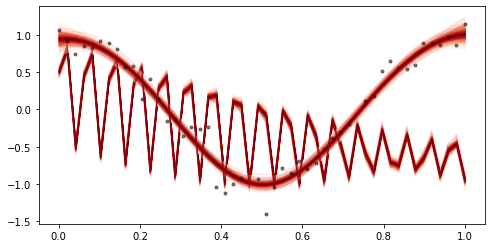

In [18]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 50:100], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 1], x)
plt.show()

### Option2: Implement ICM (one kernel) by using pm.gp.cov.Kron with pm.gp.Marginal

In [19]:
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((50, 1), (3, 1), (150, 2))

In [20]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)    
    
    cov_func = pm.gp.cov.Kron([cov, coreg])    
    sigma = pm.HalfNormal("sigma", sigma=3)    
    gp = pm.gp.Marginal(cov_func=cov_func)    
    y_ = gp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [21]:
cov(x).eval().shape, coreg(task_i).eval().shape, cov_func(X).eval().shape

((50, 50), (3, 3), (150, 150))

In [22]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 113 seconds.


CPU times: user 5min 7s, sys: 9min 28s, total: 14min 35s
Wall time: 1min 58s


#### Prediction

In [23]:
xnew = np.linspace(-0.5, 1.5, 200)
Xnew = pm.math.cartesian(xnew, task_i)

In [24]:
with model:
    preds = gp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

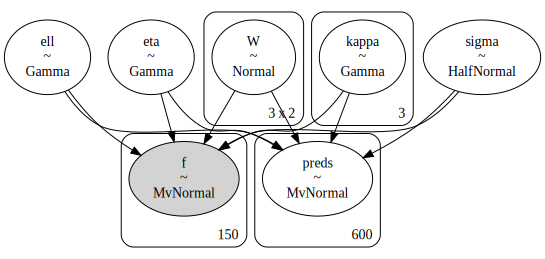

In [25]:
pm.model_to_graphviz(model)

In [26]:
Xnew.shape

(600, 2)

In [27]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 600)

#### Plot the GP prediction

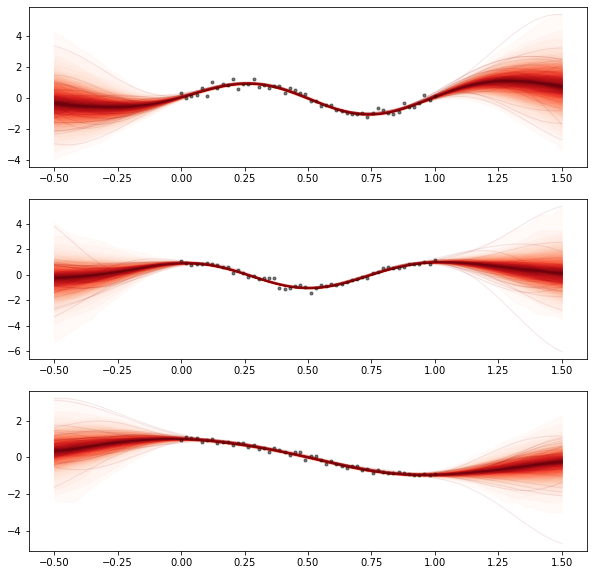

In [28]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [29]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",-0.196,2.235,-4.661,3.618,0.148,0.105,230.0,309.0,NaN
"W[0, 1]",-0.252,2.315,-4.299,4.648,0.151,0.107,235.0,364.0,NaN
"W[1, 0]",0.289,2.426,-4.444,4.414,0.189,0.134,170.0,326.0,NaN
"W[1, 1]",-0.017,2.256,-4.803,3.972,0.142,0.101,248.0,259.0,NaN
"W[2, 0]",-0.163,1.254,-2.523,2.233,0.084,0.087,302.0,108.0,NaN
"W[2, 1]",-0.029,1.019,-2.110,1.836,0.052,0.061,404.0,205.0,NaN
ell,0.334,0.041,0.259,0.404,0.002,0.002,381.0,268.0,NaN
eta,0.615,0.238,0.255,1.034,0.012,0.009,377.0,348.0,NaN
kappa[0],1.853,1.398,0.075,4.113,0.067,0.048,305.0,236.0,NaN
kappa[1],1.797,1.467,0.044,4.505,0.075,0.053,258.0,183.0,NaN


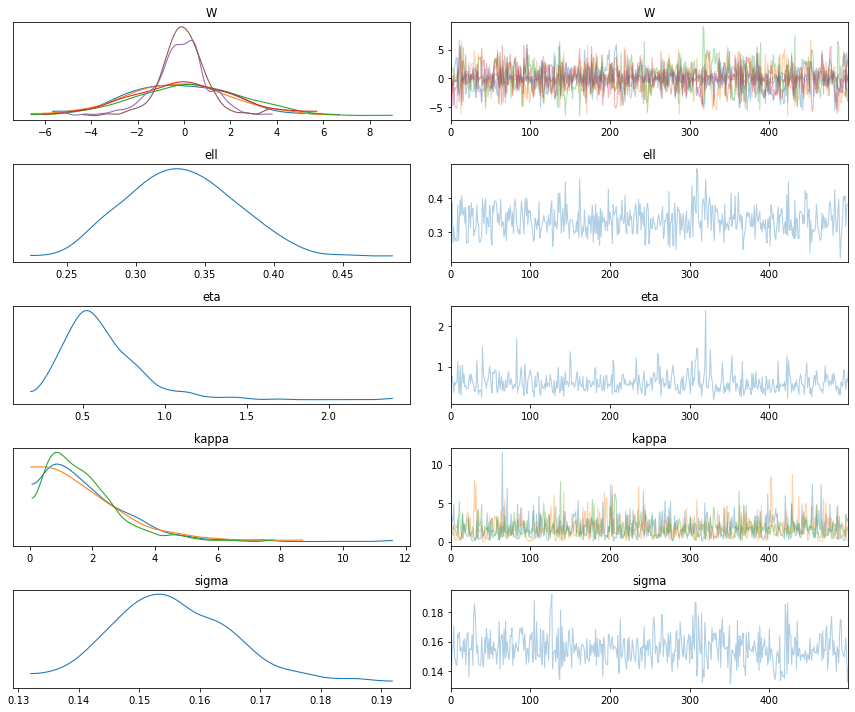

In [30]:
az.plot_trace(gp_trace);
plt.tight_layout()

In [31]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 04 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

matplotlib: 3.5.2
arviz     : 0.12.1
pymc      : 4.1.5
numpy     : 1.22.4

Watermark: 2.3.0

